In [0]:
# import pyspark class Row from module sql
from pyspark.sql import *

# Create Example Data - Departments and Employees

# Create the Departments
department1 = Row(id='123456', name='Computer Science')
department2 = Row(id='789012', name='Mechanical Engineering')
department3 = Row(id='345678', name='Theater and Drama')
department4 = Row(id='901234', name='Indoor Recreation')

# Create the Employees
Employee = Row("firstName", "lastName", "email", "salary")
employee1 = Employee('michael', 'armbrust', 'no-reply@berkeley.edu', 100000)
employee2 = Employee('xiangrui', 'meng', 'no-reply@stanford.edu', 120000)
employee3 = Employee('matei', None, 'no-reply@waterloo.edu', 140000)
employee4 = Employee(None, 'wendell', 'no-reply@berkeley.edu', 160000)
employee5 = Employee('michael', 'jackson', 'no-reply@neverla.nd', 80000)

# Create the DepartmentWithEmployees instances from Departments and Employees
departmentWithEmployees1 = Row(department=department1, employees=[employee1, employee2])
departmentWithEmployees2 = Row(department=department2, employees=[employee3, employee4])
departmentWithEmployees3 = Row(department=department3, employees=[employee5, employee4])
departmentWithEmployees4 = Row(department=department4, employees=[employee2, employee3])

print(department1)
print(employee2)
print(departmentWithEmployees1.employees[0].email)

Row(id='123456', name='Computer Science')
Row(firstName='xiangrui', lastName='meng', email='no-reply@stanford.edu', salary=120000)
no-reply@berkeley.edu

In [0]:
departmentsWithEmployeesSeq1 = [departmentWithEmployees1, departmentWithEmployees2]
df1 = spark.createDataFrame(departmentsWithEmployeesSeq1)

display(df1)

departmentsWithEmployeesSeq2 = [departmentWithEmployees3, departmentWithEmployees4]
df2 = spark.createDataFrame(departmentsWithEmployeesSeq2)

display(df2)

department,employees
"List(123456, Computer Science)","List(List(michael, armbrust, no-reply@berkeley.edu, 100000), List(xiangrui, meng, no-reply@stanford.edu, 120000))"
"List(789012, Mechanical Engineering)","List(List(matei, null, no-reply@waterloo.edu, 140000), List(null, wendell, no-reply@berkeley.edu, 160000))"


department,employees
"List(345678, Theater and Drama)","List(List(michael, jackson, no-reply@neverla.nd, 80000), List(null, wendell, no-reply@berkeley.edu, 160000))"
"List(901234, Indoor Recreation)","List(List(xiangrui, meng, no-reply@stanford.edu, 120000), List(matei, null, no-reply@waterloo.edu, 140000))"


In [0]:
unionDF = df1.union(df2)
display(unionDF)

department,employees
"List(123456, Computer Science)","List(List(michael, armbrust, no-reply@berkeley.edu, 100000), List(xiangrui, meng, no-reply@stanford.edu, 120000))"
"List(789012, Mechanical Engineering)","List(List(matei, null, no-reply@waterloo.edu, 140000), List(null, wendell, no-reply@berkeley.edu, 160000))"
"List(345678, Theater and Drama)","List(List(michael, jackson, no-reply@neverla.nd, 80000), List(null, wendell, no-reply@berkeley.edu, 160000))"
"List(901234, Indoor Recreation)","List(List(xiangrui, meng, no-reply@stanford.edu, 120000), List(matei, null, no-reply@waterloo.edu, 140000))"


In [0]:
# Remove the file if it exists
dbutils.fs.rm("/tmp/databricks-df-example.parquet", True)
unionDF.write.parquet("/tmp/databricks-df-example.parquet")

In [0]:
parquetDF = spark.read.parquet("/tmp/databricks-df-example.parquet")
display(parquetDF)

department,employees
"List(789012, Mechanical Engineering)","List(List(matei, null, no-reply@waterloo.edu, 140000), List(null, wendell, no-reply@berkeley.edu, 160000))"
"List(345678, Theater and Drama)","List(List(michael, jackson, no-reply@neverla.nd, 80000), List(null, wendell, no-reply@berkeley.edu, 160000))"
"List(901234, Indoor Recreation)","List(List(xiangrui, meng, no-reply@stanford.edu, 120000), List(matei, null, no-reply@waterloo.edu, 140000))"
"List(123456, Computer Science)","List(List(michael, armbrust, no-reply@berkeley.edu, 100000), List(xiangrui, meng, no-reply@stanford.edu, 120000))"


In [0]:
from pyspark.sql.functions import explode

explodeDF = unionDF.select(explode("employees").alias("e"))
flattenDF = explodeDF.selectExpr("e.firstName", "e.lastName", "e.email", "e.salary")

flattenDF.show()

+---------+--------+--------------------+------+
firstName|lastName| email|salary|
+---------+--------+--------------------+------+
 michael|armbrust|no-reply@berkeley...|100000|
 xiangrui| meng|no-reply@stanford...|120000|
 matei| null|no-reply@waterloo...|140000|
 null| wendell|no-reply@berkeley...|160000|
 michael| jackson| no-reply@neverla.nd| 80000|
 null| wendell|no-reply@berkeley...|160000|
 xiangrui| meng|no-reply@stanford...|120000|
 matei| null|no-reply@waterloo...|140000|
+---------+--------+--------------------+------+

In [0]:
filterDF = flattenDF.filter(flattenDF.firstName == "xiangrui").sort(flattenDF.lastName)
display(filterDF)

firstName,lastName,email,salary
xiangrui,meng,no-reply@stanford.edu,120000
xiangrui,meng,no-reply@stanford.edu,120000


In [0]:
from pyspark.sql.functions import col, asc

# Use `|` instead of `or`
filterDF = flattenDF.filter((col("firstName") == "xiangrui") | (col("firstName") == "michael")).sort(asc("lastName"))
display(filterDF)

firstName,lastName,email,salary
michael,armbrust,no-reply@berkeley.edu,100000
michael,jackson,no-reply@neverla.nd,80000
xiangrui,meng,no-reply@stanford.edu,120000
xiangrui,meng,no-reply@stanford.edu,120000


In [0]:
nonNullDF = flattenDF.fillna("--")
display(nonNullDF)

firstName,lastName,email,salary
michael,armbrust,no-reply@berkeley.edu,100000
xiangrui,meng,no-reply@stanford.edu,120000
matei,--,no-reply@waterloo.edu,140000
--,wendell,no-reply@berkeley.edu,160000
michael,jackson,no-reply@neverla.nd,80000
--,wendell,no-reply@berkeley.edu,160000
xiangrui,meng,no-reply@stanford.edu,120000
matei,--,no-reply@waterloo.edu,140000


In [0]:
from pyspark.sql.functions import countDistinct

countDistinctDF = nonNullDF.select("firstName", "lastName")\
  .groupBy("firstName")\
  .agg(countDistinct("lastName").alias("distinct_last_names"))

display(countDistinctDF)

firstName,distinct_last_names
xiangrui,1
matei,1
michael,2
--,1


In [0]:
countDistinctDF.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[firstName#127], functions=[finalmerge_count(distinct merge count#154L) AS count(lastName#128)#148L])
 +- Exchange hashpartitioning(firstName#127, 200), ENSURE_REQUIREMENTS, [id=#731]
 +- HashAggregate(keys=[firstName#127], functions=[partial_count(distinct lastName#128) AS count#154L])
 +- HashAggregate(keys=[firstName#127, lastName#128], functions=[])
 +- Exchange hashpartitioning(firstName#127, lastName#128, 200), ENSURE_REQUIREMENTS, [id=#727]
 +- HashAggregate(keys=[firstName#127, lastName#128], functions=[])
 +- Project [coalesce(e#78.firstName, --) AS firstName#127, coalesce(e#78.lastName, --) AS lastName#128]
 +- Generate explode(employees#42), false, [e#78]
 +- Union
 :- Project [employees#42]
 : +- Filter ((size(employees#42, true) > 0) AND isnotnull(employees#42))
 : +- Scan ExistingRDD[department#41,employees#42]
 +- Project [employees#46]
 +- Filter ((size(employees#46, true) > 0) AND isnotnull(employees#46))
 +- Scan ExistingRDD[department#45,employees#46]

In [0]:
# register the DataFrame as a temp view so that we can query it using SQL
nonNullDF.createOrReplaceTempView("databricks_df_example")

# Perform the same query as the DataFrame above and return ``explain``
countDistinctDF_sql = spark.sql('''
  SELECT firstName, count(distinct lastName) AS distinct_last_names
  FROM databricks_df_example
  GROUP BY firstName
''')

countDistinctDF_sql.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[firstName#127], functions=[finalmerge_count(distinct merge count#203L) AS count(lastName#128)#199L])
 +- Exchange hashpartitioning(firstName#127, 200), ENSURE_REQUIREMENTS, [id=#894]
 +- HashAggregate(keys=[firstName#127], functions=[partial_count(distinct lastName#128) AS count#203L])
 +- HashAggregate(keys=[firstName#127, lastName#128], functions=[])
 +- Exchange hashpartitioning(firstName#127, lastName#128, 200), ENSURE_REQUIREMENTS, [id=#890]
 +- HashAggregate(keys=[firstName#127, lastName#128], functions=[])
 +- Project [coalesce(e#78.firstName, --) AS firstName#127, coalesce(e#78.lastName, --) AS lastName#128]
 +- Generate explode(employees#42), false, [e#78]
 +- Union
 :- Project [employees#42]
 : +- Filter ((size(employees#42, true) > 0) AND isnotnull(employees#42))
 : +- Scan ExistingRDD[department#41,employees#42]
 +- Project [employees#46]
 +- Filter ((size(employees#46, true) > 0) AND isnotnull(employees#46))
 +- Scan ExistingRDD[department#45,employees#46]

In [0]:
salarySumDF = nonNullDF.agg({"salary" : "sum"})
display(salarySumDF)

sum(salary)
1020000


In [0]:
type(nonNullDF.salary)

Out[14]: pyspark.sql.column.Column

In [0]:
nonNullDF.describe("salary").show()

+-------+------------------+
summary| salary|
+-------+------------------+
 count| 8|
 mean| 127500.0|
 stddev|28157.719063467175|
 min| 80000|
 max| 160000|
+-------+------------------+

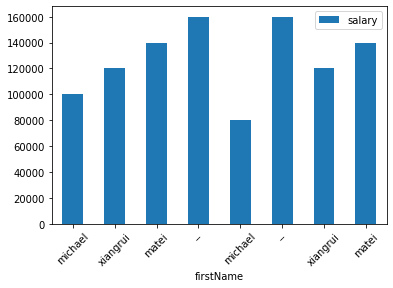

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
plt.clf()
pdDF = nonNullDF.toPandas()
pdDF.plot(x='firstName', y='salary', kind='bar', rot=45)
display()

In [0]:
dbutils.fs.rm("/tmp/databricks-df-example.parquet", True)

Out[17]: True